# PSF Plotting Guide
Use this notebook as a guide for plotting some PSFs performance as a function of radius (in arcseconds). This is the function you want.

```
def get_psf_metrics_over_field(directory='./', oversamp=3, seed=10):
    """
    Print some PSF metrics vs. wavelength and field position for PSFs
    computed by MAOS. Closed-loop.

    Inputs:
    ------------
    directory        : string, default is current directory
        Directory where MAOS simulation results live

    oversamp         : int, default=3

    seed             : int, default=10
        Simulation seed (seed value for which MAOS simulation was run)

    Outputs:
    ------------
    wavelengths      : array, dtype=float
        Array of wavelengths for which MAOS simulation was run and for
        which output metrics were calculated

    strehl_values    : array, dtype=float
        Array of Strehl values for each wavelength

    fwhm_gaus_values : array, dtype=float
        Array of FWHM values for Gaussians fit to each MAOS PSF at
        each wavelength

    fwhm_emp_values  : array, dtype=float
        Array of empirical FWHM values for each MAOS PSF. Empirical
        FWHM is calculated by locating the pixel with the largest flux,
        dividing that flux by 2, finding the nearest pixel with this halved 
        flux value, and computing the distance between them. This quantity
        is then converted to micro-arcsec (mas) using the MAOS pixel scale
        (arcsec/px) from the MAOS PSF header

    r_ee80_values    : array, dtype=float
        Array of radii for each MAOS PSF. At each wavelength, a radius
        is computed on the MAOS PSF, within which 80% of the total
        image flux is contained.
    """
    #print("Looking in %s for simulation results..." % directory)  
    fits_files = glob.glob(directory + f'evlpsfcl_{seed}_x*_y*.fits')
    psf_all_wvls = fits.open(fits_files[0])
    nwvl = len(psf_all_wvls)
    npos = len(fits_files)

    psf_all_wvls.close()

    xpos = np.zeros((npos, nwvl), dtype=int)
    ypos = np.zeros((npos, nwvl), dtype=int)
    wavelengths = np.zeros((npos, nwvl), dtype=float)
    strehl_values = np.zeros((npos, nwvl), dtype=float)
    fwhm_gaus_values = np.zeros((npos, nwvl), dtype=float)
    fwhm_emp_values = np.zeros((npos, nwvl), dtype=float)
    r_ee50_values = np.zeros((npos, nwvl), dtype=float)
    r_ee80_values = np.zeros((npos, nwvl), dtype=float)
 
    for xx in range(npos):
        psf_all_wvls = fits.open(fits_files[xx])

        file_name = fits_files[xx].split('/')[-1]
        file_root = file_name.split('.')[0]
        tmp = file_root.split('_')
        tmpx = int(tmp[2][1:])
        tmpy = int(tmp[3][1:])
        #print('xx = ', tmpx, 'yy = ', tmpy)

        for pp in range(nwvl):
            xpos[xx, pp] = tmpx
            ypos[xx, pp] = tmpy
            
            psf = psf_all_wvls[pp].data
            hdr = psf_all_wvls[pp].header
            mets = metrics.calc_psf_metrics_single(psf, hdr['DP'], 
                                                   oversamp=oversamp)
            wavelengths[xx, pp] = hdr["WVL"] * 1.0e6
            strehl_values[xx, pp] = mets["strehl"]
            fwhm_gaus_values[xx, pp] = mets["emp_fwhm"] * 1.0e3
            fwhm_emp_values[xx, pp] = mets["fwhm"] * 1.0e3
            r_ee50_values[xx, pp] = mets["ee50"] * 1.0e3
            r_ee80_values[xx, pp] = mets["ee80"] * 1.0e3


        psf_all_wvls.close()
        
    return xpos, ypos, wavelengths, strehl_values, fwhm_gaus_values, fwhm_emp_values, r_ee50_values, r_ee80_values
```

## You should understand what the function is doing

In [117]:
# IMPORT NECESSARY PACKAGES
from paarti.utils import maos_utils
import matplotlib.pyplot as plt
import numpy as np
import importlib
from scipy.interpolate import UnivariateSpline 
importlib.reload(maos_utils)

<module 'paarti.utils.maos_utils' from 'C:\\Users\\TrevorN\\code\\paarti\\paarti\\utils\\maos_utils.py'>

In [119]:
# CONSTANTS
seed = 1 # default
wavelength_index = 0 # 432 nm
psfs_directory = 'psfs_over_field/' # directory that contains all of out PSF files

In [219]:
# Calling the maos_utils function 
metrics = maos_utils.get_psf_metrics_over_field(directory=psfs_directory, seed=seed)

Looking in psfs_over_field/ for simulation results...
xx =  0 yy =  0
xx =  10 yy =  0
xx =  15 yy =  0
xx =  20 yy =  0
xx =  25 yy =  0
xx =  30 yy =  0
xx =  35 yy =  0
xx =  45 yy =  0
xx =  5 yy =  0
xx =  60 yy =  0


In [220]:
x, y, w, strehl, fwhm_g, fwhm_e, r_ee50, r_ee80 = np.array(metrics) # Getting all of the metrics out out our variable 
# and converting it to a numpy array

# x, x-coordinate in field-of-view
# y, y-coordinate in field-of-view
# strehl
# FWHM (gaussian)
# FWHM (empirical)
# 50% Encircled Energy
# 80% Encircled Energy


The cell below contains a multi-dimensional array. Each **row** represents ONE PSF, each column depicts a different wavelength. Those wavelengths are:
- 432 nm
- 544e nm
- 652 nm
- 810 nm
- 877 nm
- 1020 nm
- 1248 nm
- 1673 nm
- 2200 nm

So x, contains the x-coordinate on sky in arcseconds. Where 0 is the origin of our field-of-view. I will plot ONE wavelength, you should plot ALL the wavelengths.

In [222]:
# Notice how it goes, 0 then 10 and puts 5 way later? We are gonna fix that below
print(x)
print(fwhm_g)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [15. 15. 15. 15. 15. 15. 15. 15. 15.]
 [20. 20. 20. 20. 20. 20. 20. 20. 20.]
 [25. 25. 25. 25. 25. 25. 25. 25. 25.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [35. 35. 35. 35. 35. 35. 35. 35. 35.]
 [45. 45. 45. 45. 45. 45. 45. 45. 45.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [60. 60. 60. 60. 60. 60. 60. 60. 60.]]
[[ 14.67052191  15.58114825  16.97312284  19.14741678  19.59749011
   21.96386868  25.81912075  33.1381577   42.9115083 ]
 [ 16.58710293  16.77721647  18.67449524  20.14016079  20.50948355
   22.520004    26.17526338  33.1381577   42.9115083 ]
 [ 16.4527922   16.98563708  18.40186023  19.9455653   20.50948355
   22.79298371  25.81912075  32.63220192  42.9115083 ]
 [ 16.24924466  17.39498827  17.84409806  19.9455653   20.28532946
   22.520004    25.45799638  33.1381577   42.9115083 ]
 [ 96.4774197   30.93565862  19.07614323  20.71298098  21.16770862
   23.06273255  26.17526338  34.12757366  44.87792959]

I will show you how to plot one wavelength, you job is to plot ALL the wavelengths on one plot for full-width at half-maximum.

In [224]:
# For some reason the array is getting imported incorrectly, so I'm fixing that here
sort_indices = np.argsort(x[:, 0])
print(sort_indices)

[0 8 1 2 3 4 5 6 7 9]


In [225]:
# Now I am adjusting both to have the same indicies
x_sorted = x[sort_indices]
fwhm_g_sorted = fwhm_g[sort_indices]
x_val = np.linspace(0, 60, 100)
print(x_sorted)
print(fwhm_g_sorted)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [15. 15. 15. 15. 15. 15. 15. 15. 15.]
 [20. 20. 20. 20. 20. 20. 20. 20. 20.]
 [25. 25. 25. 25. 25. 25. 25. 25. 25.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [35. 35. 35. 35. 35. 35. 35. 35. 35.]
 [45. 45. 45. 45. 45. 45. 45. 45. 45.]
 [60. 60. 60. 60. 60. 60. 60. 60. 60.]]
[[ 14.67052191  15.58114825  16.97312284  19.14741678  19.59749011
   21.96386868  25.81912075  33.1381577   42.9115083 ]
 [ 15.97381378  16.5661739   17.70191175  19.74905248  19.82942114
   21.96386868  25.81912075  33.1381577   42.9115083 ]
 [ 16.58710293  16.77721647  18.67449524  20.14016079  20.50948355
   22.520004    26.17526338  33.1381577   42.9115083 ]
 [ 16.4527922   16.98563708  18.40186023  19.9455653   20.50948355
   22.79298371  25.81912075  32.63220192  42.9115083 ]
 [ 16.24924466  17.39498827  17.84409806  19.9455653   20.28532946
   22.520004    25.45799638  33.1381577   42.9115083 ]

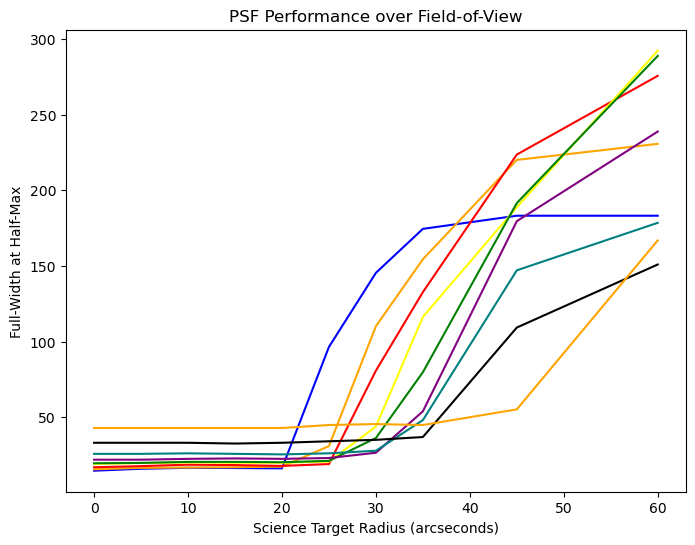

In [226]:
plt.figure(figsize=(8, 6))
plt.plot(x_sorted[:, wavelength_index], fwhm_g_sorted[:, wavelength_index], color='blue', label='432 nm')
plt.plot(x_sorted[:, wavelength_index], fwhm_g_sorted[:, wavelength_index + 1], color='orange', label='544 nm')
plt.plot(x_sorted[:, wavelength_index], fwhm_g_sorted[:, wavelength_index + 2], color='red', label='652 nm')
plt.plot(x_sorted[:, wavelength_index], fwhm_g_sorted[:, wavelength_index + 3], color='yellow', label='810 nm')
plt.plot(x_sorted[:, wavelength_index], fwhm_g_sorted[:, wavelength_index + 4], color='green', label='877 nm')
plt.plot(x_sorted[:, wavelength_index], fwhm_g_sorted[:, wavelength_index + 5], color='purple', label='1020 nm')
plt.plot(x_sorted[:, wavelength_index], fwhm_g_sorted[:, wavelength_index + 6], color='teal', label='1248 nm')
plt.plot(x_sorted[:, wavelength_index], fwhm_g_sorted[:, wavelength_index + 7], color='black', label='1673 nm')
plt.plot(x_sorted[:, wavelength_index], fwhm_g_sorted[:, wavelength_index + 8], color='orange', label='2200 nm')
plt.xlabel("Science Target Radius (arcseconds)")
plt.ylabel("Full-Width at Half-Max")
plt.title("PSF Performance over Field-of-View")

plt.show()

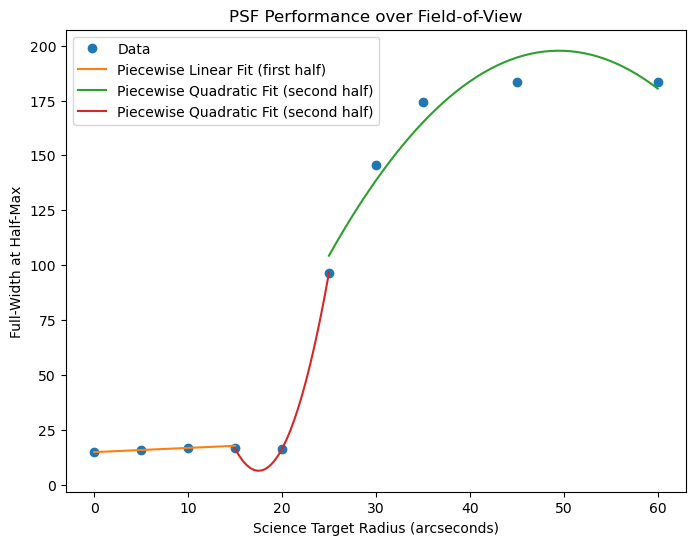

[ 0.  5. 10. 15. 20. 25. 30. 35. 45. 60.] [ 14.67052191  15.97381378  16.58710293  16.4527922   16.24924466
  96.4774197  145.45211673 174.52728486 183.21659536 183.21659536]


In [227]:
from scipy.interpolate import UnivariateSpline 
spl = UnivariateSpline(x_sorted[:, wavelength_index], fwhm_g_sorted[:, wavelength_index])
x_fit = np.linspace(0, 60, 100)
x = x_sorted[:, wavelength_index]
y =  fwhm_g_sorted[:, wavelength_index]

p1 = np.polyfit(x[:3], y[:3], 1)
# Fit for the second half (quadratic)
p2 = np.polyfit(x[5:], y[5:], 2)
p3 = np.polyfit(x[3:6], y[3:6], 2)

# Generate x values for plotting
x_fit1 = np.linspace(0, 15, 50)
y_fit1 = np.polyval(p1, x_fit1)

x_fit2 = np.linspace(25, 60, 50)
y_fit2 = np.polyval(p2, x_fit2)

x_fit3 = np.linspace(15, 25, 50)
y_fit3 = np.polyval(p3, x_fit3)


plt.figure(figsize=(8, 6))
plt.plot(x, y, 'o', label='Data')
plt.plot(x_fit1, y_fit1, label='Piecewise Linear Fit (first half)')
plt.plot(x_fit2, y_fit2, label='Piecewise Quadratic Fit (second half)')
plt.plot(x_fit3, y_fit3, label='Piecewise Quadratic Fit (second half)')
plt.xlabel("Science Target Radius (arcseconds)")
plt.ylabel("Full-Width at Half-Max")
plt.title("PSF Performance over Field-of-View")
plt.legend()
plt.show()

print(x_sorted[:, wavelength_index], fwhm_g_sorted[:, wavelength_index])

7089.951701765384


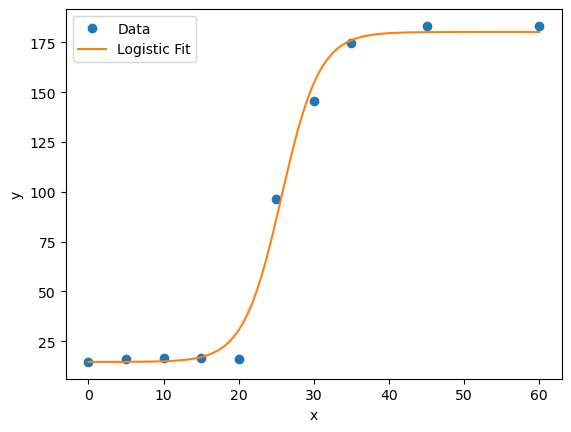

In [237]:
#defines what the curve fit will fit into, chose logistic because the curve is always increasing
def logistic(x, L, k, x0):
    return (L / (1 + np.exp(-k * (x - x0)))) + y[0]

# the variable _ is thrown away, it is a 'covarience matrix' which I do not understand, thankfully it is not needed
# we need params from the curve_fit function, p(0) is a guess of the parameters which the function correct
params, _ = curve_fit(logistic, x, y, p0=[max(y), 0.1, 30])

#will print the covarience matrix value, someone in stats can tell me what the number means
print(np.linalg.cond(_))

#the * is a unpacking operater, runs the top model with the correct parameters to fit
y_fit = logistic(x_fit, *params)

plt.plot(x, y, 'o', label='Data')
plt.plot(x_fit, y_fit, label='Logistic Fit')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


In [203]:
print(y_fit)

[ 14.67724063  14.67905112  14.68134945  14.68426705  14.68797074
  14.69267227  14.6986404   14.70621621  14.71583258  14.72803879
  14.74353177  14.76319567  14.78815191  14.81982258  14.86001049
  14.91100022  14.97568552  15.05772948  15.16176555  15.29364884
  15.46076902  15.67243779  15.94036518  16.27923967  16.70742558
  17.24778765  17.92864277  18.78482181  19.85879478  21.20176506
  22.87456821  24.94811324  27.50298082  30.62765786  34.41477898
  38.95473218  44.32617889  50.58355945  57.74258349  65.76595513
  74.55279401  83.93573273  93.68880242 103.54670964 113.23261478
 122.48852701 131.10145533 138.92002564 145.85954864 151.89688907
 157.05861537 161.40638804 165.02278645 167.99950231 170.42863493
 172.39699576 173.98289904 175.25478517 176.27106821 177.08071973
 177.72423543 178.23474903 178.63914845 178.95911365 179.21203799
 179.41182114 179.56953671 179.69398556 179.79214904 179.86955688
 179.93058387 179.97868796 180.01660034 180.04647701 180.07001914
 180.08856

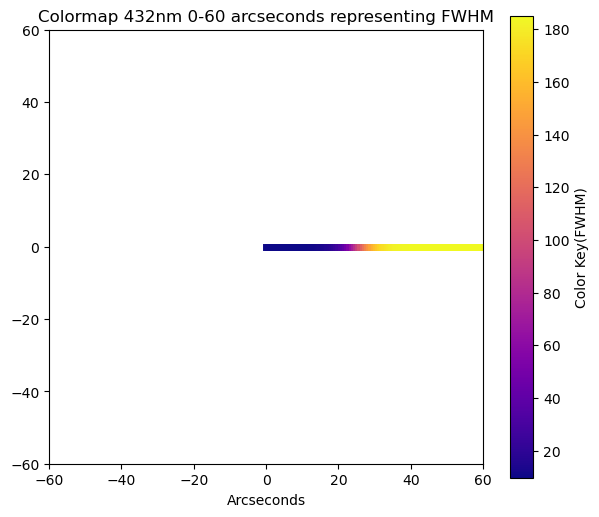

In [205]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

x = x_fit
y = y_fit

#normalizes the color map, i.e. changes the bottom of the colormap to fit the min and max of y
norm = mcolors.Normalize(vmin=min(y), vmax=max(y))

colormap = cm.plasma  # You can also use 'plasma', 'cividis', 'jet', etc.

fig, ax = plt.subplots(figsize=(7, 6))


#Separates the line into small line segments with with value x[i] to x[i+1] and sets y to 0  
for i in range(len(x) - 1):
    color = colormap(norm(y[i]))
    ax.plot([x[i], x[i+1]], [0, 0], color=color, linewidth=5)

ax.plot([-60, 0], [0, 0], linewidth=0)

plt.colorbar(sm, label='Color Key(FWHM)', ax = ax)

#sets lim to make 60 x 60 arcsecond view
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

ax.set_aspect('equal', 'box')

plt.xlabel('Arcseconds')
plt.title('Colormap 432nm 0-60 arcseconds representing FWHM')
plt.show()